In [1]:
!pip install optuna
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import optuna

# Assuming 'data' is your DataFrame
def categorize_recidivism(num_offenders):
    if num_offenders <= 50:
        return 0  # Class 0: Minimal to Low recidivism (0-50)
    elif 51 <= num_offenders <= 150:
        return 1  # Class 1: Moderate recidivism (51-150)
    elif 151 <= num_offenders <= 250:
        return 2  # Class 2: High recidivism (151-250)
    elif 251 <= num_offenders <= 400:
        return 3  # Class 3: Very High recidivism (251-400)
    else:
        return 4  # Class 4: Ultra High recidivism (400+)

# Apply the categorization to the target variable
data=pd.read_csv("final_data-3.csv")
data['Recidivism_Class'] = data['Number of Habitual Offenders'].apply(categorize_recidivism)

# Split the data into features and target
X = data.drop(columns=['Number of Habitual Offenders', 'Category', 'State/UT', 'Recidivism_Class'])
y = data['Recidivism_Class']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna with XGBClassifier
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 10.0)
    }

    # Train the XGBClassifier
    model = XGBClassifier(objective='multi:softmax', random_state=42, **params, num_class=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters and accuracy score
best_params = study.best_params
best_score = study.best_value
print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

# Final model with best parameters
final_model1 = XGBClassifier(objective='multi:softmax', random_state=42, **best_params, num_class=4)
final_model1.fit(X_train, y_train)

# Test on unseen data
y_pred = final_model1.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy Score on test data:", final_accuracy)

# Save predictions and actual values to a CSV
results_df = pd.DataFrame({
    'Actual Class': y_test,
    'Predicted Class': y_pred
})
results_df.to_csv('classification_results.csv', index=False)
print("The classification results have been saved to 'classification_results.csv'.")

[I 2025-07-10 20:08:37,954] A new study created in memory with name: no-name-acfc9dc5-324f-448f-9155-b4db7da4366d
/tmp/ipython-input-2-3767538217.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-2-3767538217.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10.0),
/tmp/ipython-input-2-3767538217.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda':

Best Parameters: {'n_estimators': 393, 'learning_rate': 0.05166696244376275, 'max_depth': 10, 'subsample': 0.7829277813198033, 'colsample_bytree': 0.9640652800231249, 'reg_alpha': 1.019529943916577, 'reg_lambda': 0.5356023048280545}
Best Accuracy Score: 0.8461538461538461
Final Accuracy Score on test data: 0.8461538461538461
The classification results have been saved to 'classification_results.csv'.


# New section

In [ ]:
#final model 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import optuna

# Assuming 'data' is your DataFrame with 'Number of Habitual Offenders' and 'Convicts Admitted During the Year'
data = pd.read_csv("final_data-3.csv")

# Calculate the recidivism rate
data['Recidivism_Rate'] = data['Number of Habitual Offenders'] / data['Number of Convicts Admitted During the year']

# Define the classification based on recidivism rate
def categorize_recidivism_rate(rate):
    if rate <= 0.1:
        return 0  # Class 0: Recidivism rate 0-1
    elif 0.1 < rate <= 0.5:
        return 1  # Class 1: Recidivism rate 1-3
    elif 0.5 < rate <= 1:
        return 2  # Class 2: Recidivism rate 3-5
    elif 1 < rate <= 5:
        return 3  # Class 3: Recidivism rate 5-10
    else:
        return 4  # Class 4: Recidivism rate 10+

# Apply the categorization to the target variable
data['Recidivism_Rate_Class'] = data['Recidivism_Rate'].apply(categorize_recidivism_rate)

# Split the data into features and target
X = data.drop(columns=['Number of Habitual Offenders', 'Category', 'State/UT', 'Recidivism_Rate', 'Recidivism_Rate_Class'])
y = data['Recidivism_Rate_Class']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna with XGBClassifier
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 10.0)
    }

    # Train the XGBClassifier
    model = XGBClassifier(objective='multi:softmax', random_state=42, **params, num_class=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters and accuracy score
best_params = study.best_params
best_score = study.best_value
print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

# Final model with best parameters
final_model2 = XGBClassifier(objective='multi:softmax', random_state=42, **best_params, num_class=4)
final_model2.fit(X_train, y_train)

# Test on unseen data
y_pred = final_model2.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy Score on test data:", final_accuracy)

# Save predictions and actual values to a CSV
results_df = pd.DataFrame({
    'Actual Class': y_test,
    'Predicted Class': y_pred
})
results_df.to_csv('recidivism_rate_classification_results.csv', index=False)
print("The classification results have been saved to 'recidivism_rate_classification_results.csv'.")


[I 2024-11-12 08:52:48,202] A new study created in memory with name: no-name-e281dd88-08a6-48e2-9e03-e15105be35dd
<ipython-input-5-ea660889775f>:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-5-ea660889775f>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10.0),
<ipython-input-5-ea660889775f>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugge

Best Parameters: {'n_estimators': 111, 'learning_rate': 0.03241258282466593, 'max_depth': 6, 'subsample': 0.8996994715789755, 'colsample_bytree': 0.7806118498010303, 'reg_alpha': 0.10559233030987342, 'reg_lambda': 0.1381689512702831}
Best Accuracy Score: 0.8
Final Accuracy Score on test data: 0.8
The classification results have been saved to 'recidivism_rate_classification_results.csv'.


In [ ]:
# Check the distribution of classes in the target
print(data['Recidivism_Rate_Class'].value_counts())

# Verify unique classes in y_train
print("Unique classes in y_train:", np.unique(y_train))

# Modify num_class based on actual classes
actual_num_classes = len(np.unique(y_train))
final_model = XGBClassifier(objective='multi:softmax', random_state=42, **best_params, num_class=actual_num_classes)


Recidivism_Rate_Class
0    154
1     32
3     18
4     12
2      8
Name: count, dtype: int64
Unique classes in y_train: [0 1 2 3 4]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import optuna

# Assuming 'data', 'classifi', and 'rati' are your DataFrames
data = pd.read_csv("final_data-3.csv")
classifi = pd.read_csv("classification_results.csv")
rati = pd.read_csv("recidivism_rate_classification_results.csv")

# Apply the categorization to the target variable
data['Recidivism_Class'] = classifi['Predicted Class']
data['rate'] = rati['Predicted Class']
X = data.drop(columns=['Number of Habitual Offenders', 'Category', 'State/UT'])
y = data['Number of Habitual Offenders']

# Define the boundaries for each recidivism rate class
rate_class_bounds = {
    0: (0, 0.1),        # Class 0: 0-1% recidivism rate
    1: (0.1, 0.5),        # Class 1: 1-3%
    2: (0.5, 1),        # Class 2: 3-5%
    3: (1, 2),
    4: (2,50)# Class 3: 5-10%
}

# Calculate the recidivism rate for each row
data['recidivism_rate'] = data['Number of Habitual Offenders'] / data['Number of Convicts Admitted During the year']

# Handle outliers in the target variable 'y'
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
outliers = (y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR))
y = y[~outliers]
X = X[~outliers]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True)
    }

    model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_absolute_error(y_test, y_pred)
    return score

# Run Optuna for hyperparameter tuning with MAE minimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters and MAE score
best_params = study.best_params
best_score = study.best_value
print("Best Parameters:", best_params)
print("Best MAE Score:", best_score)

# Final model with best parameters
final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(X_train, y_train)

# Test on unseen data
y_pred = final_model.predict(X_test)

final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)
print("Final MAE Score on test data:", final_mae)
print("Final R² Score on test data:", final_r2)
# Post-process predictions to fit within recidivism rate class bounds




[I 2024-11-12 08:57:02,839] A new study created in memory with name: no-name-edf2110e-119d-44e6-ae36-f7c0d0d64924
[I 2024-11-12 08:57:06,290] Trial 0 finished with value: 42.76232538223267 and parameters: {'n_estimators': 237, 'learning_rate': 0.016078514773086514, 'max_depth': 5, 'subsample': 0.9792970113689435, 'colsample_bytree': 0.6440071629851559, 'reg_alpha': 8.959508502176154, 'reg_lambda': 3.5273803865286038}. Best is trial 0 with value: 42.76232538223267.
[I 2024-11-12 08:57:07,203] Trial 1 finished with value: 48.89634702578187 and parameters: {'n_estimators': 408, 'learning_rate': 0.013268367229053212, 'max_depth': 10, 'subsample': 0.7413642712008868, 'colsample_bytree': 0.6958931692777408, 'reg_alpha': 1.0344723138148415, 'reg_lambda': 0.20731285423242501}. Best is trial 0 with value: 42.76232538223267.
[I 2024-11-12 08:57:07,572] Trial 2 finished with value: 49.50589786618948 and parameters: {'n_estimators': 322, 'learning_rate': 0.059878375180381305, 'max_depth': 5, 'subs

Best Parameters: {'n_estimators': 350, 'learning_rate': 0.05577188403675116, 'max_depth': 8, 'subsample': 0.9746280356375794, 'colsample_bytree': 0.9381109650083818, 'reg_alpha': 0.018435507486504236, 'reg_lambda': 4.455549781004029}
Best MAE Score: 37.269931791722776
Final MAE Score on test data: 37.269931791722776
Final R² Score on test data: 0.7101805210113525


In [ ]:
# Apply the categorization to the target variable
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
test_data_df=pd.read_csv("test_data.csv")
test_data_df['Recidivism_Class'] = final_model1.predict(test_data_df.drop(columns=['Number of Habitual Offenders', 'Category' ,'State/UT']))

def categorize_recidivism_rate(rate):
    if rate <= 0.1:
        return 0  # Class 0: Recidivism rate 0-1
    elif 0.1 < rate <= 0.5:
        return 1  # Class 1: Recidivism rate 1-3
    elif 0.5 < rate <= 1:
        return 2  # Class 2: Recidivism rate 3-5
    elif 1 < rate <= 5:
        return 3  # Class 3: Recidivism rate 5-10
    else:
        return 4  # Class 4: Recidivism rate 10+

# Apply the categorization to the target variable
test_data_df['Recidivism_Rate'] = test_data_df['Number of Habitual Offenders'] / test_data_df['Number of Convicts Admitted During the year']
test_data_df['rate'] = final_model2.predict(test_data_df.drop(columns=['Number of Habitual Offenders', 'Category' ,'State/UT','Recidivism_Class','Recidivism_Rate']))

# Separate features and target variable
features = test_data_df.drop(columns=['Number of Habitual Offenders', 'Category' , 'State/UT', ])
actual_values = test_data_df['Number of Habitual Offenders']

# Handle outliers in the target variable 'Number of Habitual Offenders'
Q1 = actual_values.quantile(0.25)
Q3 = actual_values.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers (values outside 1.5*IQR from Q1 and Q3)
outliers = (actual_values < (Q1 - 1.5 * IQR)) | (actual_values > (Q3 + 1.5 * IQR))

# Remove outliers from the target variable and the corresponding rows in features (X)
test_data_df = test_data_df[~outliers]
features = test_data_df.drop(columns=['Number of Habitual Offenders', 'Category' ,'State/UT','Recidivism_Rate'])
actual_values = test_data_df['Number of Habitual Offenders']

# Preprocess the data if necessary (e.g., scaling)
# Ensure test data columns align with training data
scaled_features = scaler.transform(features)

# Make predictions
predictions = final_model.predict(scaled_features)

# Calculate predicted recidivism rate for each row
total_convicts = features['Number of Convicts Admitted During the year']
predicted_recidivism_rate = (predictions / total_convicts) * 100
actual_recidivism_rate = (actual_values / total_convicts) * 100

# Calculate error metrics
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = mean_squared_error(actual_values, predictions, squared=False)

# Avoid division by zero in percentage error
error_percentages = abs(predictions - actual_values) / actual_values.replace(0, np.nan) * 100
average_error_percentage = error_percentages.mean(skipna=True)

# Create a DataFrame with actual values, predictions, and recidivism rates
results_df = pd.DataFrame({
    'Actual Values': actual_values,
    'Predicted Values': predictions,
    'Actual Recidivism Rate (%)': actual_recidivism_rate,
    'Predicted Recidivism Rate (%)': predicted_recidivism_rate
})

# Save results to a CSV file
results_df.to_csv('prediction_results.csv', index=False)

# Display results
print("\nPrediction Results:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print("\nThe actual and predicted values have been saved to 'prediction_results.csv'.")



Prediction Results:
Mean Absolute Error: 47.58
Mean Squared Error: 4749.62
Root Mean Squared Error: 68.92

The actual and predicted values have been saved to 'prediction_results.csv'.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


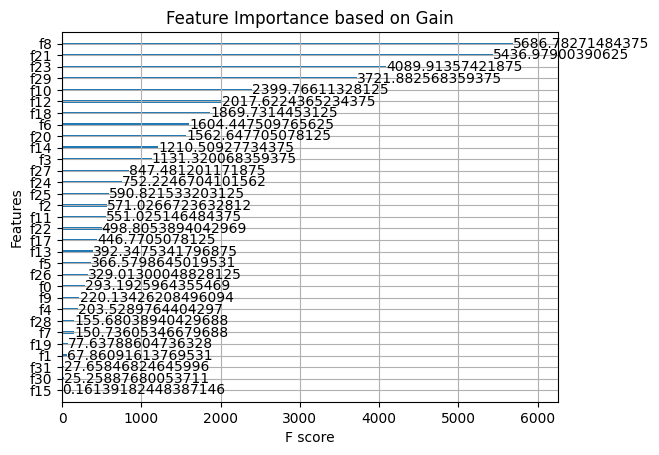

In [ ]:
# Get feature importance from the trained model
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(final_model, importance_type='gain')
plt.title('Feature Importance based on Gain')
plt.show()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 36 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Category                                                           224 non-null    object 
 1   State/UT                                                           224 non-null    object 
 2   Number of Convicts Admitted During the year                        224 non-null    int64  
 3   Number of Habitual Offenders                                       224 non-null    int64  
 4   Agriculture                                                        224 non-null    int64  
 5   Carpentry                                                          224 non-null    int64  
 6   Canning                                                            224 non-null    int64  
 7   Tailoring                 

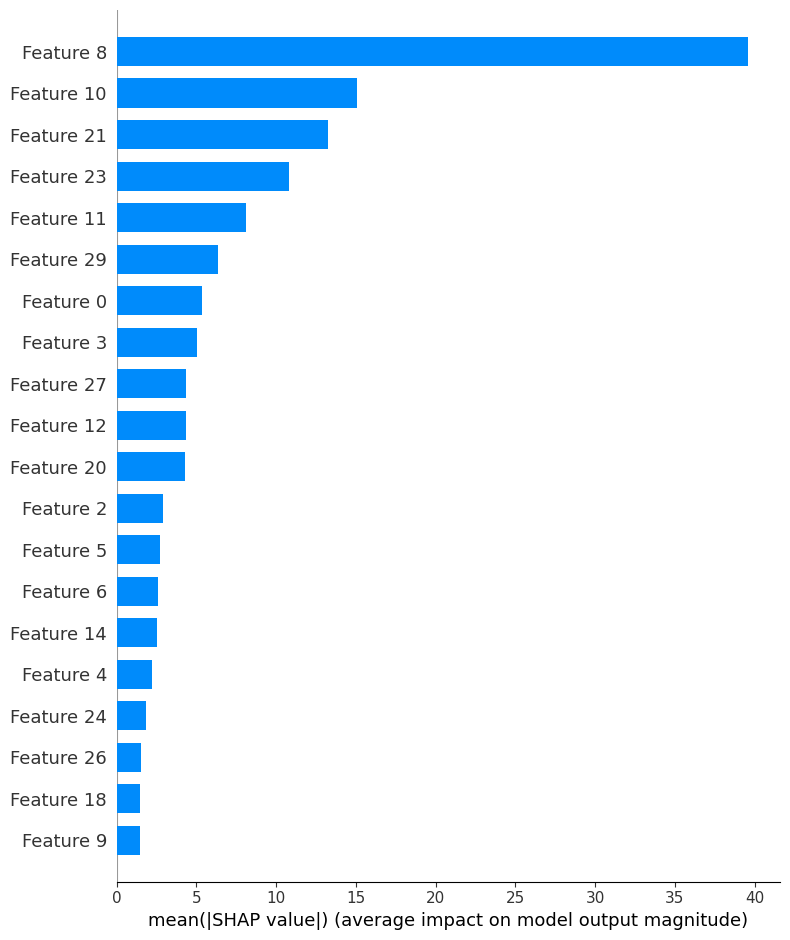

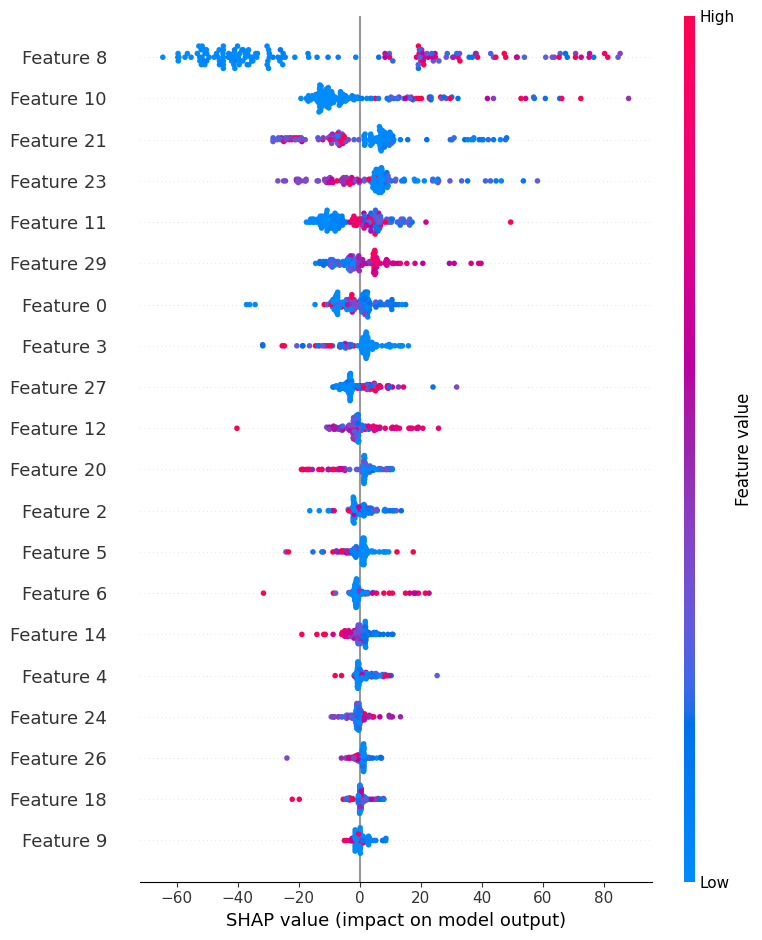

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)
